In [1]:
import faro
import faro.proto.proto_types as pt
import os
import pyvision as pv
import cv2
import time
import csv

In [2]:
class FaroDetectionOptions(object):
    #user could change these variable : User-defined variables
    def __init__(self):
        #root file
        self.results_root_path = '/home/nv5/Research/FaceRecognition/faro/Notebooks/results'
        self.csvfiles_log = 'csvfiles_log'
        #Directory to save images with bounding boxes
        self.detect_log = 'detect_log'
        #Directory to save cropped face images (128*128)
        self.face_log = 'face_log'
        #Set to True if you want to save only the detection with 
        #the highest detection score (confidence)
        self.best = False
        #Detection Thresh - Retinaface uses 0.5 in their examples
        self.detect_thresh = 0.5
        #Set min size. If the bouding box of the face detected is
        #less that min_size then it will be discarded.
        self.min_size = 0
        #Set the maximum number of images it can process
        self.max_images = None
        self.max_size = None

class FaroClientConnectionOptions(object):
    
    def __init__(self):
        self.max_async = faro.DEFAULT_MAX_ASYNC
        self.max_message_size = faro.DEFAULT_MAX_MESSAGE_SIZE
        self.detect_port = faro.DEFAULT_PORT
        self.rec_port = faro.DEFAULT_PORT
        self.verbose = True

        

In [3]:
client_options = FaroClientConnectionOptions()
face_client = faro.FaceClient(client_options)
is_ready,status = face_client.status(verbose=client_options.verbose)
if not is_ready:
    print("ERROR: the FaRO service is not ready.")
    print(status)
    exit(-1)
else:
    if client_options.verbose:
        print('Connection to FaRO service established. [ algorithm: %s ]'%(status.algorithm))



<bound method FaceClient.status of <faro.FaceClient.FaceClient object at 0x7f6f8f77d5c0>>
<class 'faro.proto.face_service_pb2.FaceServiceInfo'> status: READY
detection_support: true
extract_support: true
score_support: true
score_type: NEG_DOT
detection_threshold: 0.5
match_threshold: -0.42838144302368164
algorithm: "ArcFace-model arcface_r100_v1"

Connection to FaRO service established. [ algorithm: ArcFace-model arcface_r100_v1 ]


In [4]:
def getFilesToProcess(args):
    images = []
    videos = []
    for each in args:
        print(each)
        if os.path.isfile(each) and pv.isImage(each):
            images.append(each)
        elif os.path.isfile(each) and pv.isVideo(each):
            videos.append(each)
        elif os.path.isdir(each):
            for path,dirs,files in os.walk(each):
                for filename in files:
                    #print(filename)
                    filepath = os.path.join(path,filename)
                    if os.path.isfile(filepath) and pv.isImage(filepath):
                        images.append(filepath)
                    if os.path.isfile(filepath) and pv.isVideo(filepath):
                        videos.append(filepath)
        else :
            raise ValueError("Cannot determine filetype:"+each)

    print("Found %d images and %d videos."%(len(images),len(videos)))
    return images, videos

In [5]:
def preprocessImage(im_interest, doptions):
    scale = 1.0
    while max(*im_interest.shape[:2]) > doptions.max_size:
        if max(*im_interest.shape[:2]) > 2*doptions.max_size:
            im = cv2.pyrDown(im)
            scale *= 0.5
        else:
            w,h = im.shape[:2]
            s = doptions.max_size/max(w,h)
            scale *= s
            w = int(s*w)
            h = int(s*h)
            im = cv2.resize(im,(w,h))
    return im

In [6]:
detection_options = FaroDetectionOptions()
if not os.path.isdir(detection_options.results_root_path):
    os.makedirs(detection_options.results_root_path)
#define data path 
data_dir = ['../tests/data']
image_list, video_list = getFilesToProcess(data_dir)

../tests/data
Found 10 images and 0 videos.


In [7]:
def process_image_detections(each):
    im, results, options, media_type = each
    if results.done():
        recs = results.result().face_records
        i = 0
        dimg = None
        csv_file = None
        for idx, face in enumerate(recs):
            base_name, ext = os.path.splitext(os.path.basename(face.source))
            # Filter faces based on min size
            size = min(face.detection.location.width,face.detection.location.height)
            if size < options.min_size:
                continue
    
            # Process Detections
            if csv_file is None:
                image_detection_file = open(os.path.join(options.results_root_path, 
                                                         options.csvfiles_log, media_type, base_name + '.csv'), 'w')
                file_identifier = csv.writer(image_detection_file)
                
                if len(face.landmarks) > 0:
                    file_identifier.writerow(['source','frame','detect_id','type','score','x','y','w','h',
                                             'lmark_id_1','lmark_x','lmark_y', 'lmark_id_2','lmark_x',
                                             'lmark_y','lmark_id_3','lmark_x','lmark_y','lmark_id_4',
                                             'lmark_x','lmark_y','lmark_id_5','lmark_x','lmark_y'])
                else:
                    file_identifier.writerow(['source','frame','detect_id','type','score','x','y','w','h'])
                
                csv_file = -1
                        
                                 
                
            if len(face.landmarks) > 0:
                file_identifier.writerow([face.source,
                                        face.frame,
                                        i,
                                        face.detection.detection_class,
                                        face.detection.score,
                                        face.detection.location.x,
                                        face.detection.location.y,
                                        face.detection.location.width,
                                        face.detection.location.height,
                                        face.landmarks[0].landmark_id,face.landmarks[0].location.x, face.landmarks[0].location.y,
                                        face.landmarks[1].landmark_id,face.landmarks[1].location.x, face.landmarks[1].location.y,
                                        face.landmarks[2].landmark_id,face.landmarks[2].location.x, face.landmarks[2].location.y,
                                        face.landmarks[3].landmark_id,face.landmarks[3].location.x, face.landmarks[3].location.y,
                                        face.landmarks[4].landmark_id,face.landmarks[4].location.x, face.landmarks[4].location.y])
            else:
                file_identifier.writerow([face.source,
                                        face.frame,
                                        i,
                                        face.detection.detection_class,
                                        face.detection.score,
                                        face.detection.location.x,
                                        face.detection.location.y,
                                        face.detection.location.width,
                                        face.detection.location.height])

                
            if options.detect_log:
                detect_log_dir = os.path.join(options.results_root_path, options.detect_log, media_type)
                if not os.path.exists(detect_log_dir):
                    os.makedirs(detect_log_dir, exist_ok=True)
                rect = pt.rect_proto2pv(face.detection.location)
                if dimg is None:
                    dimg = pv.Image(im[:,:,::-1])
                dimg.annotateThickRect(rect)
                dimg.annotateLabel(pv.Point(rect.x+5,rect.y+5),face.detection.detection_class)
                dimg.annotateLabel(pv.Point(rect.x+5,rect.y+20),
                                    "Score: %0.4f"%(face.detection.score,), color='yellow')
                if len(face.landmarks) > 0:
                    for each_lmark in face.landmarks:
                            dimg.annotateCircle(pv.Point(each_lmark.location.x, each_lmark.location.y), 
                                                radius=3, color = 'green', fill='green')
                
            
            if options.face_log:
                face_log_dir = os.path.join(options.results_root_path, options.face_log, media_type)
                if not os.path.exists(face_log_dir):
                    os.makedirs(face_log_dir, exist_ok=True)
                #print(face.detection.location)
                
                rect = pt.rect_proto2pv(face.detection.location)
                rect = rect.rescale(1.5)
                affine = pv.AffineFromRect(rect,(128,128))
    
                try:
                    pvim = pv.Image(im[:,:,::-1])
                    view = affine(pvim)
                    if len(face.landmarks) > 0:
                        for each_lmark in face.landmarks:
                            transformed_lmarks = affine(pv.Point(each_lmark.location.x, each_lmark.location.y))
                            view.annotateCircle(transformed_lmarks, radius=3, color = 'green', fill='green')
  
                    base_name, ext = os.path.splitext(os.path.basename(face.source))
                    out_path = os.path.join(face_log_dir,
                                            os.path.basename(base_name)+'_face_%03d'%(face.detection.detection_id,)+ext)
                    
                    view.asAnnotated().save(out_path)
                    print('Saving face:',out_path)
                except:
                    print("WARNING: Image not processed correctly:",face.source)
            i += 1
        
        if options.detect_log:
            dimg.asAnnotated().save(os.path.join(detect_log_dir,
                                                     os.path.basename(base_name) + ext))
        image_detection_file.close()
        return False
    return True


In [8]:
def process_images(ilist, doptions):
    image_count = 0
    detect_queue = []
    start_time = time.time()
    for each_img in ilist:
        im = cv2.imread(each_img)
        
        if im is None:
            continue
        # convert BGR to RGB
        im = im[:,:,::-1]
        if doptions.max_size is not None:
            im, scale = preprocessImage(im, doptions)
        results = face_client.detect(im, best=doptions.best, 
                             threshold=doptions.detect_thresh, 
                             min_size=doptions.min_size,
                             run_async=True, 
                             source=each_img, 
                             frame=-1)
        detect_queue.append([im, results, doptions, 'image'])
        detect_queue = list(filter(process_image_detections, detect_queue))
        image_count += 1
        if doptions.max_images is not None and image_count >= options.max_images:
            break 
            
    while len(detect_queue):
        detect_queue = list(filter(process_image_detections,detect_queue))
        time.sleep(0.05)
        
        end_time = time.time() - start_time
    print("Processed %d images in %0.3f seconds: %f images/second"%(image_count,end_time - start_time,
                                                                    image_count/(end_time - start_time)))
        

In [9]:
if not os.path.isdir(os.path.join(detection_options.results_root_path, detection_options.csvfiles_log, 'image')):
    os.makedirs(os.path.join(detection_options.results_root_path, detection_options.csvfiles_log, 'image'))
process_images(image_list, detection_options)

Saving face: /home/nv5/Research/FaceRecognition/faro/Notebooks/results/face_log/image/trump1_face_000.jpg
Saving face: /home/nv5/Research/FaceRecognition/faro/Notebooks/results/face_log/image/trump1_face_001.jpg
Saving face: /home/nv5/Research/FaceRecognition/faro/Notebooks/results/face_log/image/trump1_face_002.jpg
Saving face: /home/nv5/Research/FaceRecognition/faro/Notebooks/results/face_log/image/trump1_face_003.jpg
Saving face: /home/nv5/Research/FaceRecognition/faro/Notebooks/results/face_log/image/trump1_face_004.jpg
Saving face: /home/nv5/Research/FaceRecognition/faro/Notebooks/results/face_log/image/trump1_face_005.jpg
Saving face: /home/nv5/Research/FaceRecognition/faro/Notebooks/results/face_log/image/trump1_face_006.jpg
Saving face: /home/nv5/Research/FaceRecognition/faro/Notebooks/results/face_log/image/trump1_face_007.jpg
Saving face: /home/nv5/Research/FaceRecognition/faro/Notebooks/results/face_log/image/trump1_face_008.jpg
Saving face: /home/nv5/Research/FaceRecognitio

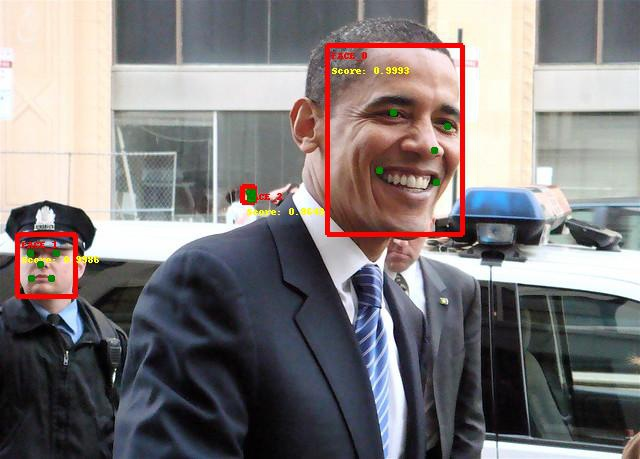

In [13]:
#View one output

if detection_options.detect_log is not None:
    from glob import glob
    bbox_imgs = glob(os.path.join(detection_options.results_root_path, detection_options.detect_log, 'image','*'))
    img = pv.Image(bbox_imgs[5])
img.show()


65


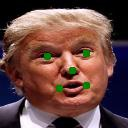

In [14]:
if detection_options.face_log is not None:
    from glob import glob
    bbox_imgs =  glob(os.path.join(detection_options.results_root_path, detection_options.face_log, 'image','*'))
    print(len(bbox_imgs))
    img_path = bbox_imgs[1]

img = pv.Image(img_path)
img.show()

In [ ]:
def process_video_detections(each):
    global video_header_flag
    im, results, options, file_identifier, media_type = each
    if results.done():
        recs = results.result().face_records
        i = 0
        detect_log_dir = None
        frame_id = None
        dimg = None
        for idx, face in enumerate(recs):
            base_name, ext = os.path.splitext(os.path.basename(face.source))
            # Filter faces based on min size
            size = min(face.detection.location.width,face.detection.location.height)
            if size < options.min_size:
                continue
    
            if video_header_flag:
                if len(face.landmarks) > 0:
                    file_identifier.writerow(['source','frame','detect_id','type','score','x','y','w','h',
                                         'lmark_id_1','lmark_x','lmark_y', 'lmark_id_2','lmark_x',
                                         'lmark_y','lmark_id_3','lmark_x','lmark_y','lmark_id_4',
                                         'lmark_x','lmark_y','lmark_id_5','lmark_x','lmark_y'])
                else:
                    file_identifier.writerow(['source','frame','detect_id','type','score','x','y','w','h'])
                
                video_header_flag = False
                                    

            if len(face.landmarks) > 0:
                file_identifier.writerow([face.source,
                                        face.frame,
                                        i,
                                        face.detection.detection_class,
                                        face.detection.score,
                                        face.detection.location.x,
                                        face.detection.location.y,
                                        face.detection.location.width,
                                        face.detection.location.height,
                                        face.landmarks[0].landmark_id,face.landmarks[0].location.x, face.landmarks[0].location.y,
                                        face.landmarks[1].landmark_id,face.landmarks[1].location.x, face.landmarks[1].location.y,
                                        face.landmarks[2].landmark_id,face.landmarks[2].location.x, face.landmarks[2].location.y,
                                        face.landmarks[3].landmark_id,face.landmarks[3].location.x, face.landmarks[3].location.y,
                                        face.landmarks[4].landmark_id,face.landmarks[4].location.x, face.landmarks[4].location.y])
            else:
                file_identifier.writerow([face.source,
                                        face.frame,
                                        i,
                                        face.detection.detection_class,
                                        face.detection.score,
                                        face.detection.location.x,
                                        face.detection.location.y,
                                        face.detection.location.width,
                                        face.detection.location.height])
                
            if options.detect_log:
                detect_log_dir = os.path.join(options.results_root_path, options.detect_log, media_type, base_name)
                frame_id = face.frame
                if not os.path.exists(detect_log_dir):
                    os.makedirs(detect_log_dir, exist_ok=True)
                
                rect = pt.rect_proto2pv(face.detection.location)
                if dimg is None:
                    dimg = pv.Image(im[:,:,::-1])
                dimg.annotateThickRect(rect)
                dimg.annotateLabel(pv.Point(rect.x+5,rect.y+5),face.detection.detection_class)
                dimg.annotateLabel(pv.Point(rect.x+5,rect.y+20),
                                    "Score: %0.4f"%(face.detection.score,), color='yellow')
                if len(face.landmarks) > 0:
                    for each_lmark in face.landmarks:
                            dimg.annotateCircle(pv.Point(each_lmark.location.x, each_lmark.location.y), 
                                                radius=3, color = 'green', fill='green')
                
            
            if options.face_log:
                face_log_dir = os.path.join(options.results_root_path, options.face_log, media_type, base_name)
                if not os.path.exists(face_log_dir):
                    os.makedirs(face_log_dir, exist_ok=True)
                
                rect = pt.rect_proto2pv(face.detection.location)
                rect = rect.rescale(1.5)
                affine = pv.AffineFromRect(rect,(128,128))
                try:    
                    pvim = pv.Image(im[:,:,::-1])
                    view = affine(pvim)
                    out_path = os.path.join(face_log_dir,os.path.basename(base_name)+
                                            '_Frame_%06d'%(face.frame) +
                                            '_face_%03d'%(face.detection.detection_id,)+ '.jpg')
                    if len(face.landmarks) > 0:
                        for each_lmark in face.landmarks:
                            transformed_lmarks = affine(pv.Point(each_lmark.location.x, each_lmark.location.y))
                            view.annotateCircle(transformed_lmarks, radius=3, color = 'green', fill='green')
                    view.asAnnotated().save(out_path)
                    print('Saving face:',out_path)
                except:
                    print("WARNING: Image not processed correctly:",face.source)
            i += 1
        
        if options.detect_log and detect_log_dir is not None:
            dimg.asAnnotated().save(os.path.join(detect_log_dir,
                                                 os.path.basename(base_name) + '_Frame_%06d'%(frame_id) + '.jpg'))
        return False
    return True



In [ ]:
def process_videos(each_video, doptions):
    detect_queue = []
    #Read Video
    video = pv.Video(each_video)
    videoname, ext = os.path.splitext(os.path.basename(each_video))
    fid = open(os.path.join(doptions.results_root_path,
                            doptions.csvfiles_log, 'video', videoname + '.csv') , 'w')
    video_detections_csv = csv.writer(fid)
    
    start_time = time.time()
    for frame_id, each_frame in enumerate(video):

        each_frame = each_frame.asOpenCV2()[:,:,::-1]#convert to opencv and then bgrtorgb
        if doptions.max_size is not None:
            each_frame, scale = preprocessImage(each_frame, doptions)
        results = face_client.detect(each_frame, best=doptions.best, 
                             threshold=doptions.detect_thresh, 
                             min_size=doptions.min_size,
                             run_async=True, 
                             source=each_video, 
                             frame=frame_id)
        detect_queue.append([each_frame, results, doptions, video_detections_csv, 'video'])
        detect_queue = list(filter(process_video_detections, detect_queue))

        
    while len(detect_queue):
        detect_queue = list(filter(process_video_detections,detect_queue))
        time.sleep(0.05)
    
    
        
    end_time = time.time() - start_time
    print("Processed %d frames in %0.3f seconds: %f images/second"%(frame_id+1,end_time - start_time,
                                                                    (frame_id+1)/(end_time - start_time)))
    
    fid.close()

In [ ]:
video_header_flag = None
if not os.path.isdir(os.path.join(detection_options.results_root_path, detection_options.csvfiles_log, 'video')):
    os.makedirs(os.path.join(detection_options.results_root_path, detection_options.csvfiles_log, 'video'))
for each_video in video_list:
    global video_header_flag 
    video_header_flag = True
    process_videos(each_video, detection_options)

In [ ]:
#read images from detect_log dir and convert it to a video and play it
